In [2]:
!pip install warcio pandas
!pip install newspaper3k lxml[html_clean]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 53.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 7.2 MB/s eta 0:00:00
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13540 sha256=240e413019cb5c2cbde0c281192b951989104dea305e0fa31578c6abba7a14cd
  Stored in directory: /root/.cache/pip/wheels/fc/ab/f8/cce3a9ae6d828bd346be695f7ff54612cd22b7cbd7208d68f3
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3341 sha256=e3f545ccb46be8a628ae7f3f25e940aac1d65e72acd25c808a48eccb535b9a0a
  Stored in 

In [3]:
import requests
import gzip
import io
import warcio
import pandas as pd
import tqdm # Import tqdm
import re # Import re
from newspaper import Article # Import Article

In [4]:
# URL for GDELT GKG data
url = "http://data.gdeltproject.org/gdeltv2/20240930081500.gkg.csv.zip"

# Download and save the zipped file
response = requests.get(url, stream=True)
with open("gdelt_data.csv.zip", "wb") as file:
  for chunk in response.iter_content(chunk_size=1024):
    if chunk:
      file.write(chunk)

# Unzip the file
!unzip gdelt_data.csv.zip -d gdelt_data

# Read the CSV file into a pandas DataFrame
file_path = "gdelt_data/20240930081500.gkg.csv"
df = pd.read_csv(file_path, sep='\t', header=None)

# Add column names (replace with actual column names from GDELT documentation)
gkg_columns = [
    "GKGRECORDID", "DATE", "SourceCollectionIdentifier", "SourceCommonName",
    "DocumentIdentifier", "Counts", "V2Counts", "Themes", "V2Themes",
    "Locations", "V2Locations", "Persons", "V2Persons", "Organizations",
    "V2Organizations", "V2Tone", "Dates", "GCAM", "SharingImage",
    "RelatedImages", "SocialImageEmbeds", "SocialVideoEmbeds", "Quotations",
    "AllNames", "Amounts", "TranslationInfo", "Extras"
]
df.columns = gkg_columns

# Filter for news related to netflix (adjust column and keyword as needed)
netflix_news = df[df['Organizations'].str.contains("netflix", na=False)].copy()
netflix_news

Archive:  gdelt_data.csv.zip
  inflating: gdelt_data/20240930081500.gkg.csv  


,GKGRECORDID,DATE,SourceCollectionIdentifier,SourceCommonName,DocumentIdentifier,Counts,V2Counts,Themes,V2Themes,Locations,...,GCAM,SharingImage,RelatedImages,SocialImageEmbeds,SocialVideoEmbeds,Quotations,AllNames,Amounts,TranslationInfo,Extras
3,20240930081500-3,20240930081500,1,malverngazette.co.uk,https://www.malverngazette.co.uk/news/24617666...,NaN,NaN,UNREST_CRACKDOWN;TAX_ECON_PRICE;USPEC_POLICY1;...,"USPEC_POLICY1,1700;EPU_POLICY_POLICY,1700;UNGP...",NaN,...,"wc:304,c1.3:1,c12.1:26,c12.10:20,c12.12:10,c12...",https://www.malverngazette.co.uk/resources/ima...,NaN,NaN,NaN,NaN,"Martin Lewis,559;Money Saving Expert,763;Extra...","99,a month if they,183;99,for either,1217;",NaN,<PAGE_LINKS>https://t.co/KOW1ZZxoF3;https://tw...
208,20240930081500-208,20240930081500,1,campaignasia.com,https://www.campaignasia.com:443/article/how-c...,NaN,NaN,EPU_ECONOMY_HISTORIC;TAX_FNCACT;TAX_FNCACT_FOU...,"EPU_ECONOMY_HISTORIC,267;EPU_ECONOMY_HISTORIC,...","1#China#CH#CH#35#105#CH;4#To Cheng, Guangdong,...",...,"wc:573,c12.1:45,c12.10:78,c12.12:16,c12.13:24,...",https://cdn.i.haymarketmedia.asia/?n=campaign-...,NaN,NaN,https://youtube.com/user/CampaignAsia;,NaN,"New Marketing Paradigm',103;Charlene Ree,338;F...","70,different languages,1398;5,different labels...",NaN,<PAGE_LINKS>https://www.iabhongkong.com/joinC2...
280,20240930081500-280,20240930081500,1,tomsguide.com,https://www.tomsguide.com/entertainment/netfli...,NaN,NaN,TAX_FNCACT;TAX_FNCACT_GUIDE;,"TAX_FNCACT_GUIDE,814;TAX_FNCACT_GUIDE,1805;TAX...",1#United States#US#US#39.828175#-98.5795#US;1#...,...,"wc:1455,c1.3:2,c12.1:128,c12.10:167,c12.12:63,...",https://cdn.mos.cms.futurecdn.net/5hRcycNRCD2d...,https://img.youtube.com/vi/UKFMYWNatQM/maxresd...,NaN,https://youtube.com/vi/PRZ1ELeGepo/maxresdefau...,1477|34||Tim Dillon : This is Your Country#234...,"Tim Dillon,994;Official Trailer,1074;Official ...","12,singles for a dating,165;7,premiere,2300;7,...",NaN,<PAGE_LINKS>https://www.anrdoezrs.net/links/89...
530,20240930081500-530,20240930081500,1,thenorthernecho.co.uk,https://www.thenorthernecho.co.uk/news/2461766...,NaN,NaN,UNREST_CRACKDOWN;TAX_ECON_PRICE;USPEC_POLICY1;...,"UNGP_FORESTS_RIVERS_OCEANS,1721;USPEC_POLICY1,...",NaN,...,"wc:304,c1.3:1,c12.1:26,c12.10:20,c12.12:10,c12...",https://www.thenorthernecho.co.uk/resources/im...,NaN,NaN,NaN,NaN,"Martin Lewis,559;Money Saving Expert,763;Extra...","99,a month if they,183;99,for either,1217;",NaN,<PAGE_LINKS>https://t.co/KOW1ZZxoF3;https://tw...
552,20240930081500-552,20240930081500,1,tomsguide.com,https://www.tomsguide.com/entertainment/stream...,NaN,NaN,MANMADE_DISASTER_IMPLIED;MEDIA_MSM;WB_678_DIGI...,"ALLIANCE,1766;MANMADE_DISASTER_IMPLIED,44;MEDI...","3#Hollywood, California, United States#US#USCA...",...,"wc:654,c12.1:74,c12.10:71,c12.12:20,c12.13:19,...",https://cdn.mos.cms.futurecdn.net/PYKEwCu69pnq...,https://img.youtube.com/vi/3HraByA23eA/maxresd...,NaN,https://youtube.com/vi/FRoEjAlhmsw/maxresdefau...,NaN,"Love Is Blind',550;Blind Season,597;Official T...","7,| Official Trailer |,464;7,| Official Traile...",NaN,<PAGE_LINKS>https://www.tomsguide.com/entertai...
943,20240930081500-943,20240930081500,1,thenorthernecho.co.uk,https://www.thenorthernecho.co.uk/news/2461762...,NaN,NaN,TAX_FNCACT;TAX_FNCACT_SECRETARY;WB_696_PUBLIC_...,"SOC_GENERALCRIME,388;EPU_CATS_MIGRATION_FEAR_F...",1#United Kingdom#UK#UK#54#-4#UK,...,"wc:264,c12.1:19,c12.10:29,c12.12:11,c12.13:10,...",https://www.thenorthernecho.co.uk/resources/im...,NaN,NaN,NaN,NaN,"Culture Secretary Lisa Nandy,30;Justice Secret...",NaN,NaN,<PAGE_LINKS>https://www.mirror.co.uk/news/poli...


In [5]:
# Split V2Tone into separate columns
netflix_news[['Tone', 'Positive Score', 'Negative Score', 'Polarity', 'Activity', 'Self Direction', 'WordCount']] = netflix_news['V2Tone'].str.split(',', expand=True)

# Convert numeric columns to appropriate data types
numeric_columns = ['Tone', 'Positive Score', 'Negative Score', 'Polarity', 'Activity', 'Self Direction']
netflix_news[numeric_columns] = netflix_news[numeric_columns].astype(float).round(3)
netflix_news[['Tone', 'Positive Score', 'Negative Score', 'Polarity', 'Activity', 'Self Direction', 'WordCount']]

,Tone,Positive Score,Negative Score,Polarity,Activity,Self Direction,WordCount
3,-2.102,0.601,2.703,3.303,28.228,3.303,304
208,3.086,3.858,0.772,4.630,22.685,0.463,573
280,-0.493,4.310,4.803,9.113,20.135,1.293,1455
530,-2.102,0.601,2.703,3.303,28.228,3.303,304
552,0.682,4.502,3.820,8.322,23.602,0.955,654
943,-3.460,2.076,5.536,7.612,26.644,1.730,264


from matplotlib import pyplot as plt
_df_0['Tone'].plot(kind='hist', bins=20, title='Tone')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Positive Score'].plot(kind='hist', bins=20, title='Positive Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Negative Score'].plot(kind='hist', bins=20, title='Negative Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Polarity'].plot(kind='hist', bins=20, title='Polarity')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('WordCount').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Tone', y='Positive Score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Positive Score', y='Negative Score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Negative Score', y='Polarity', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='Polarity', y='Activity', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9['Tone'].plot(kind='line', figsize=(8, 4), title='Tone')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['Positive Score'].plot(kind='line', figsize=(8, 4), title='Positive Score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['Negative Score'].plot(kind='line', figsize=(8, 4), title='Negative Score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['Polarity'].plot(kind='line', figsize=(8, 4), title='Polarity')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['WordCount'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='Tone', y='WordCount', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['WordCount'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='Positive Score', y='WordCount', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['WordCount'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='Negative Score', y='WordCount', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_16['WordCount'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_16, x='Polarity', y='WordCount', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

/tmp/ipython-input-8-2266696088.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(_df_13, x='Tone', y='WordCount', inner='stick', palette='Dark2')


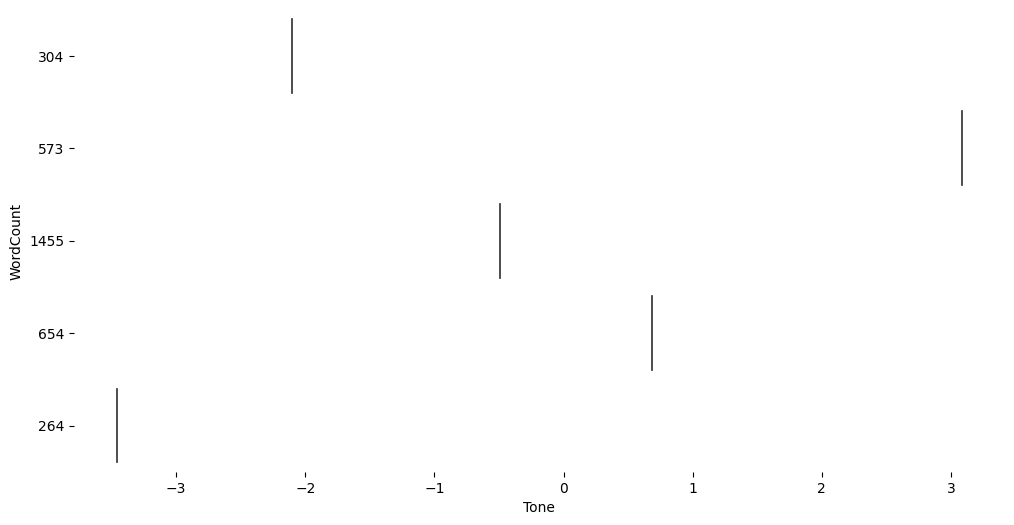

In [8]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['WordCount'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='Tone', y='WordCount', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

/tmp/ipython-input-6-2608634180.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(_df_15, x='Negative Score', y='WordCount', inner='stick', palette='Dark2')


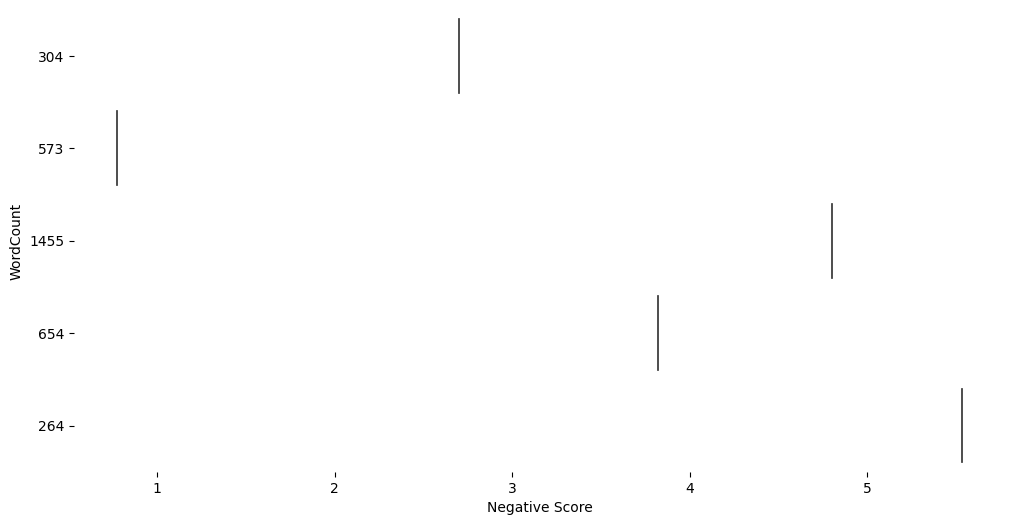

In [6]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['WordCount'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='Negative Score', y='WordCount', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

/tmp/ipython-input-7-2940945640.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(_df_16, x='Polarity', y='WordCount', inner='stick', palette='Dark2')


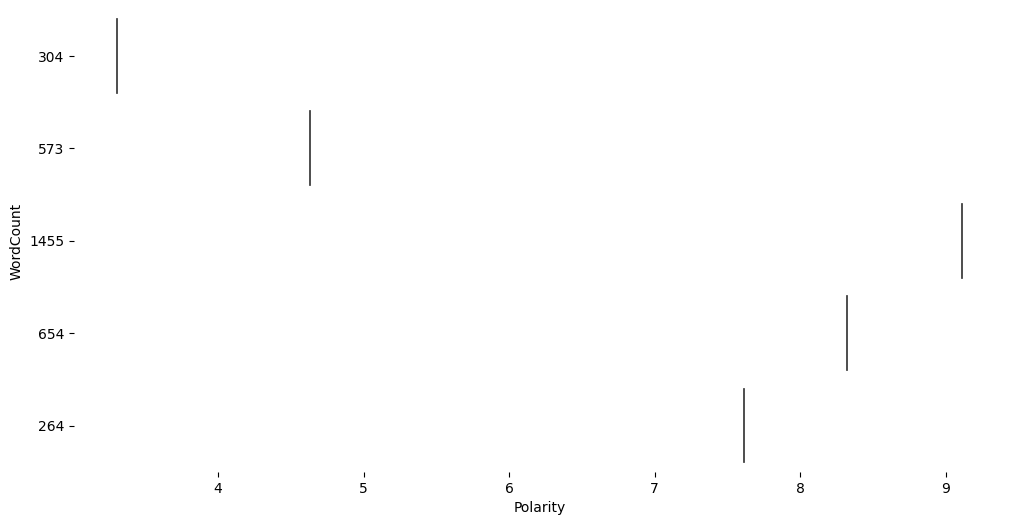

In [7]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_16['WordCount'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_16, x='Polarity', y='WordCount', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)